In [122]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
from enum import Enum
  

class OrderType(Enum):
    NoAct = 0
    Buy2Open = 1
    Sell2Open = 2
    Buy2Close = 3
    Sell2Close = 4
    
    
def csv_to_df(filepath):
    """
    加载外汇历史数据
    假设CSV包含列: Date, Open, High, Low, Close
    """
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = df.columns.str.strip()
    df.sort_index(inplace=True)
    return df


class SparseTable:
    def __init__(self, arr):
        n = len(arr)
        logn = math.floor(math.log2(n)) + 1
        self.min_table = [[0] * n for _ in range(logn)]
        self.max_table = [[0] * n for _ in range(logn)]
        
        self.min_table[0] = arr.copy()
        self.max_table[0] = arr.copy()
        
        for j in range(1, logn):
            for i in range(n - (1 << j) + 1):
                self.min_table[j][i] = min(self.min_table[j-1][i], self.min_table[j-1][i + (1 << (j-1))])
                self.max_table[j][i] = max(self.max_table[j-1][i], self.max_table[j-1][i + (1 << (j-1))])
    
    def query_min(self, l, r):
        length = r - l + 1
        k = math.floor(math.log2(length))
        return min(self.min_table[k][l], self.min_table[k][r - (1 << k) + 1])
    
    def query_max(self, l, r):
        length = r - l + 1
        k = math.floor(math.log2(length))
        return max(self.max_table[k][l], self.max_table[k][r - (1 << k) + 1])
 

    
class AMAStrategy:
    def __init__(self, fast_length=2, slow_length=30, window=10, stop_loss=0.05):
        """
        初始化自适应移动均线策略
        """
        self.fast_length = fast_length
        self.slow_length = slow_length
        self.window = window 
        self.stop_loss = stop_loss
        self.positions = []

    def check_stoploss(self, position_date, current_date, position, prices, minmax_lkup):
        """
        计算动态止损价 
        :param position_date: 头寸建立日期
        :param current_date: 当前日期
        :return: 止损交易类型
        """ 
        if position_date <= 0 or position == 0:
            return OrderType.NoAct
            
        current_price = prices[current_date]      
        # 计算基于最高价的动态止损
        if position > 0:
            # 多单，跟踪买入后的最高价
            highest_price_since_buy = minmax_lkup.query_max(position_date, current_date) 
            stop_price = highest_price_since_buy * (1 - self.stop_loss)
            if current_price <= stop_price:
                return OrderType.Sell2Close
        else:
            # 空单，跟踪买入后的最低价
            lowest_price_since_sell = minmax_lkup.query_min(position_date, current_date)
            stop_price = lowest_price_since_sell * (1 + self.stop_loss)
            if current_price >= stop_price:
                return OrderType.Buy2Close
        return OrderType.NoAct
    
    def calculate_ama(self, prices):
        n = len(prices)
        ama = np.zeros(n)
        direction = np.zeros(n)
        volatility = np.zeros(n)
        er = np.zeros(n)
        sc = np.zeros(n)
        # 初始值
        ama[0] = prices[0]
        for i in range(1, n):
            # 计算价格方向
            direction[i] = abs(prices[i] - prices[i-self.window])
            # 计算波动性
            volatility[i] = sum(abs(prices[i-j] - prices[i-j-1]) for j in range(self.window))
            # 计算效率比率(ER)
            if volatility[i] != 0:
                er[i] = direction[i] / volatility[i]
            else:
                er[i] = 0
            # 计算平滑系数(SC)
            fast_sc = 2 / (self.fast_length + 1)
            slow_sc = 2 / (self.slow_length + 1)
            sc[i] = er[i] * (fast_sc - slow_sc) + slow_sc
            sc[i] = sc[i] * sc[i]  # 平方以增强响应
            ama[i] = ama[i-1] + sc[i] * (prices[i] - ama[i-1])
        return ama 
        
    def generate_signals(self, ohlc):
        """
        生成交易信号
        返回:
        signals: 交易信号序列 (1: 买入, -1: 卖出, 0: 无信号)
        """
        import pandas_ta as ta
        trend_ind = ta.trend.adx(ohlc['High'], ohlc['Low'], ohlc['Close'])
        adx = trend_ind['ADX_14'].values
        dmp = trend_ind['DMP_14'].values
        dmn = trend_ind['DMN_14'].values
        prices = ohlc['Close'].values
        ama = self.calculate_ama(prices)
        plt.figure(figsize=(22, 10))
        # plot prices
        plt.subplot(2, 1, 1)
        plt.plot(prices, label='Price')
        plt.plot(ama, label='AMA')
        plt.subplot(2, 1, 2)
        #plot ADX
        plt.plot(adx, label='ADX')
        plt.plot(dmp, label='+DM')
        plt.plot(dmn, label='-DM')
        plt.legend()
        #
        n = len(prices)
        signals = np.zeros(n)
        # 生成交易信号
        for i in range(1, n):
            if prices[i] > ama[i] and prices[i-1] < ama[i-1] and adx[i] > 20 and dmp[i] > dmn[i]:
                signals[i] = 1  # 买入信号
            elif prices[i] < ama[i] and prices[i-1] > ama[i-1] and adx[i] > 20 and dmp[i] < dmn[i]:
                signals[i] = -1  # 卖出信号
        return signals

    def backtest(self, df, spread=0.02, commission=0.0001):
        """
        策略回测

        参数:
        df: 价格序列 (Open, High, Low, Close)
        spread: 点差
        commission: 每手佣金

        返回:
        returns: 每日收益率
        equity: 资金曲线
        """
        prices = df['Close'].values
        signals = self.generate_signals(df)
        minmaxLkup = SparseTable(prices)
        n = len(prices)
        position = 0.0
        opened_date = -1        
        equity = np.zeros(n)
        trades = np.zeros(n, dtype=np.int8)
        equity[0] = 10000  # 初始资金
        trade_size = 2000  # 每手交易规模        

        for i in range(1, n):
            equity[i] = equity[i-1]
            # 检查止损
            copy_position = position
            orderType1 = self.check_stoploss(opened_date, i, position, prices, minmaxLkup)
            # 检查信号            
            orderType2 = OrderType.NoAct
            if signals[i] == 1 and position <= 0 and orderType1 != OrderType.Sell2Close:
                orderType2 = OrderType.Buy2Open 
            elif signals[i] == -1 and position >= 0 and orderType1 != OrderType.Buy2Close:
                orderType2 = OrderType.Sell2Open
            # 执行止损交易 
            if orderType1 == OrderType.Buy2Close or (orderType2 == OrderType.Buy2Open and position < 0): # 平空仓 
                assert position < 0
                equity[i] += position * (prices[i] - prices[i-1] + spread)
                trades[i] += 1
                position = 0
            elif orderType1 == OrderType.Sell2Close or (orderType2 == OrderType.Sell2Open and position < 0): # 平多仓
                assert position > 0
                equity[i] += position * (prices[i] - prices[i-1] - spread)
                trades[i] -= 1
                position = 0
            # 执行开仓交易    
            if orderType2 == OrderType.Buy2Open: # 开多仓                    
                position = trade_size / prices[i]
                opened_date = i
                trades[i] += 1
                equity[i] -= commission
            elif orderType2 == OrderType.Sell2Open: #开空仓
                position = -trade_size / prices[i]
                opened_date = i
                trades[i] -= 1
                equity[i] -= commission
            else: # 持仓  
                equity[i] += position * (prices[i] - prices[i-1])
            self.positions.append(position)

        returns = np.diff(equity) / equity[:-1]
        return returns, equity, trades

    def plot_results(self, prices, equity, trades):
        """
        绘制回测结果

        参数:
        prices: 价格序列
        equity: 资金曲线
        """
        ama = self.calculate_ama(prices)
        # Plot buy/sell signals
        buy_dates = np.where(trades > 0)[0]
        buy_prices = prices[trades > 0]
        sell_dates = np.where(trades < 0)[0]
        sell_prices = prices[trades < 0]        
        print(sell_dates)
        print(sell_prices)
        # 价格和AMA 
        plt.figure(figsize=(22, 10))
        plt.subplot(2, 1, 1)
        # plt.plot(prices, label='Price')
        #plt.plot(ama, label='AMA')        
        plt.scatter(buy_dates, buy_prices, color='green', marker='^', s=2, label='Buy', alpha=0.8)
        plt.scatter(sell_dates, sell_prices, color='red', marker='v', s=2, label='Sell', alpha=0.8)
        plt.title('Price and Adaptive Moving Average')
        plt.legend()

        # 资金曲线
        plt.subplot(2, 1, 2)
        plt.plot(equity, label='Equity')
        plt.title('Strategy Equity Curve')        
        plt.legend()

        plt.tight_layout()
        plt.show()


策略优化建议 参数优化: 可以对fast_length、slow_length和window参数进行优化，找到最适合特定货币对和时间框架的参数组合。

过滤机制: 可以添加波动性过滤器，在市场波动过低时避免交易，减少假信号。

多时间框架确认: 结合更高时间框架的趋势判断，只交易与主趋势方向一致的信号。

风险管理: 添加止损和止盈机制，控制单笔交易的最大风险。

组合策略: 可以将AMA与其他指标(如RSI、MACD)结合，形成更稳健的交易策略。

注意事项 本策略示例使用随机生成的价格数据，实际应用中应使用真实市场数据。

外汇交易具有高风险，应在充分理解策略原理和风险后再进行实盘交易。

建议在历史数据上进行充分回测和验证后，再进行模拟交易，最后才考虑实盘应用。

点差和佣金等交易成本对策略绩效有重要影响，应根据实际交易条件进行调整。

In [126]:
# df = csv_to_df('USDJPY-1-Jun-2020.csv')
df = yf.Ticker('WMT').history(period='5y')


USD/JPY Strategy Performance:
Total Return: 1.84%
Sharpe Ratio: 0.14
Max Drawdown: 6.92%
[ 102  234  317  372  387  479  537  544  633  775  804  834  960  972
 1046 1144 1147 1156 1182]
[43.2427063  42.86702728 46.34167862 45.86060715 44.09095001 48.48186874
 39.05326843 40.20264435 46.90139389 49.93365479 50.82941437 52.21368408
 58.35666275 58.45530319 66.90296173 89.88524628 91.18850708 91.05917358
 96.70995331]


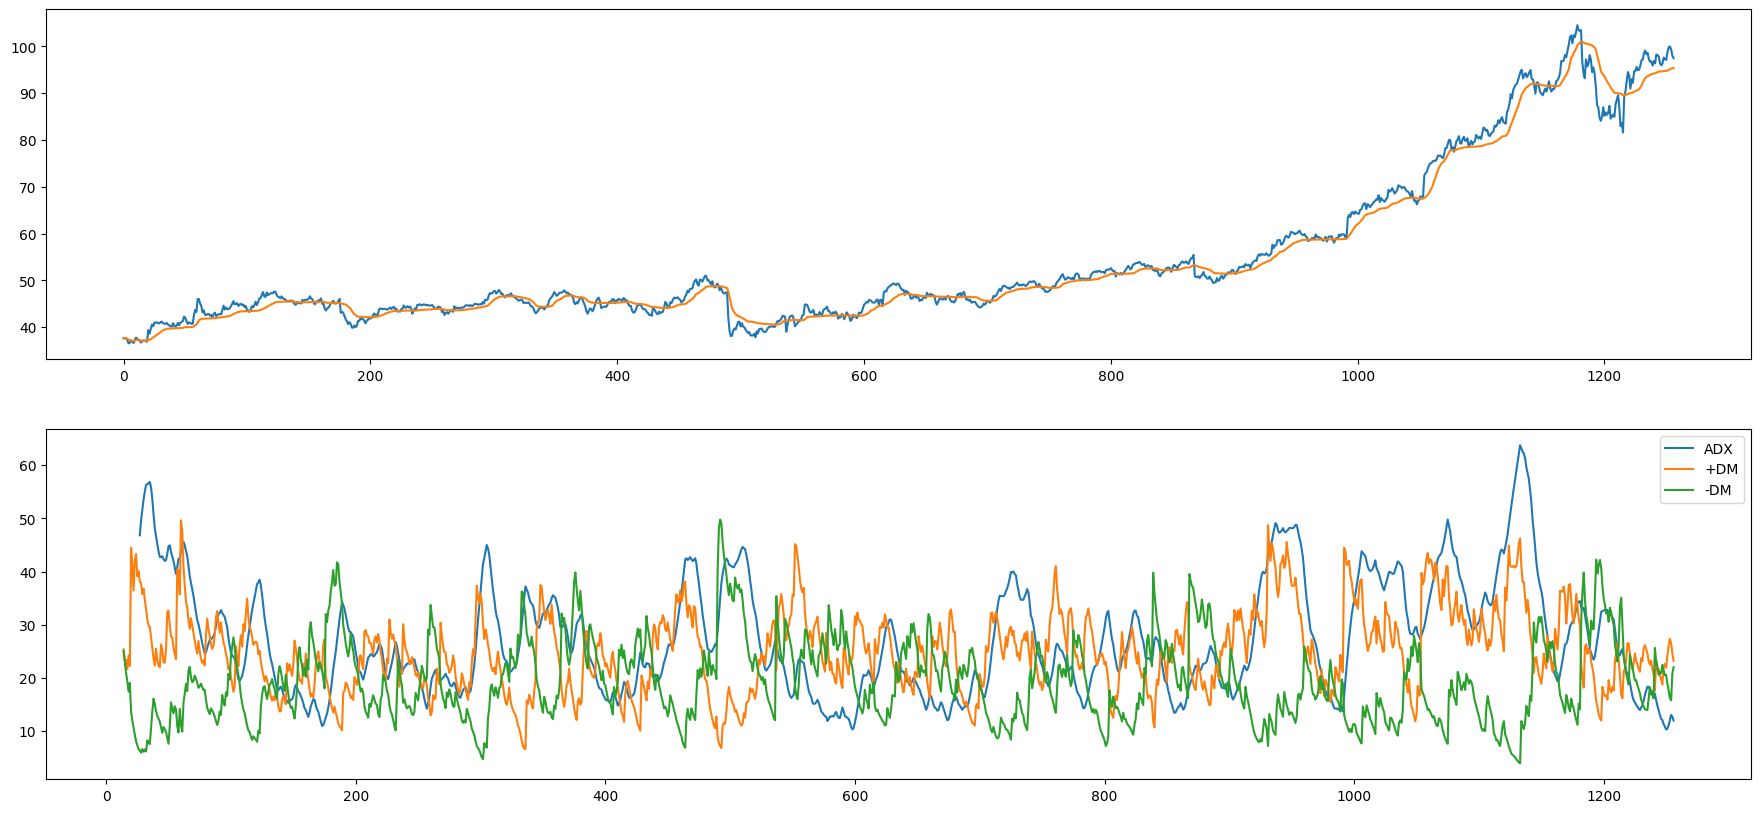

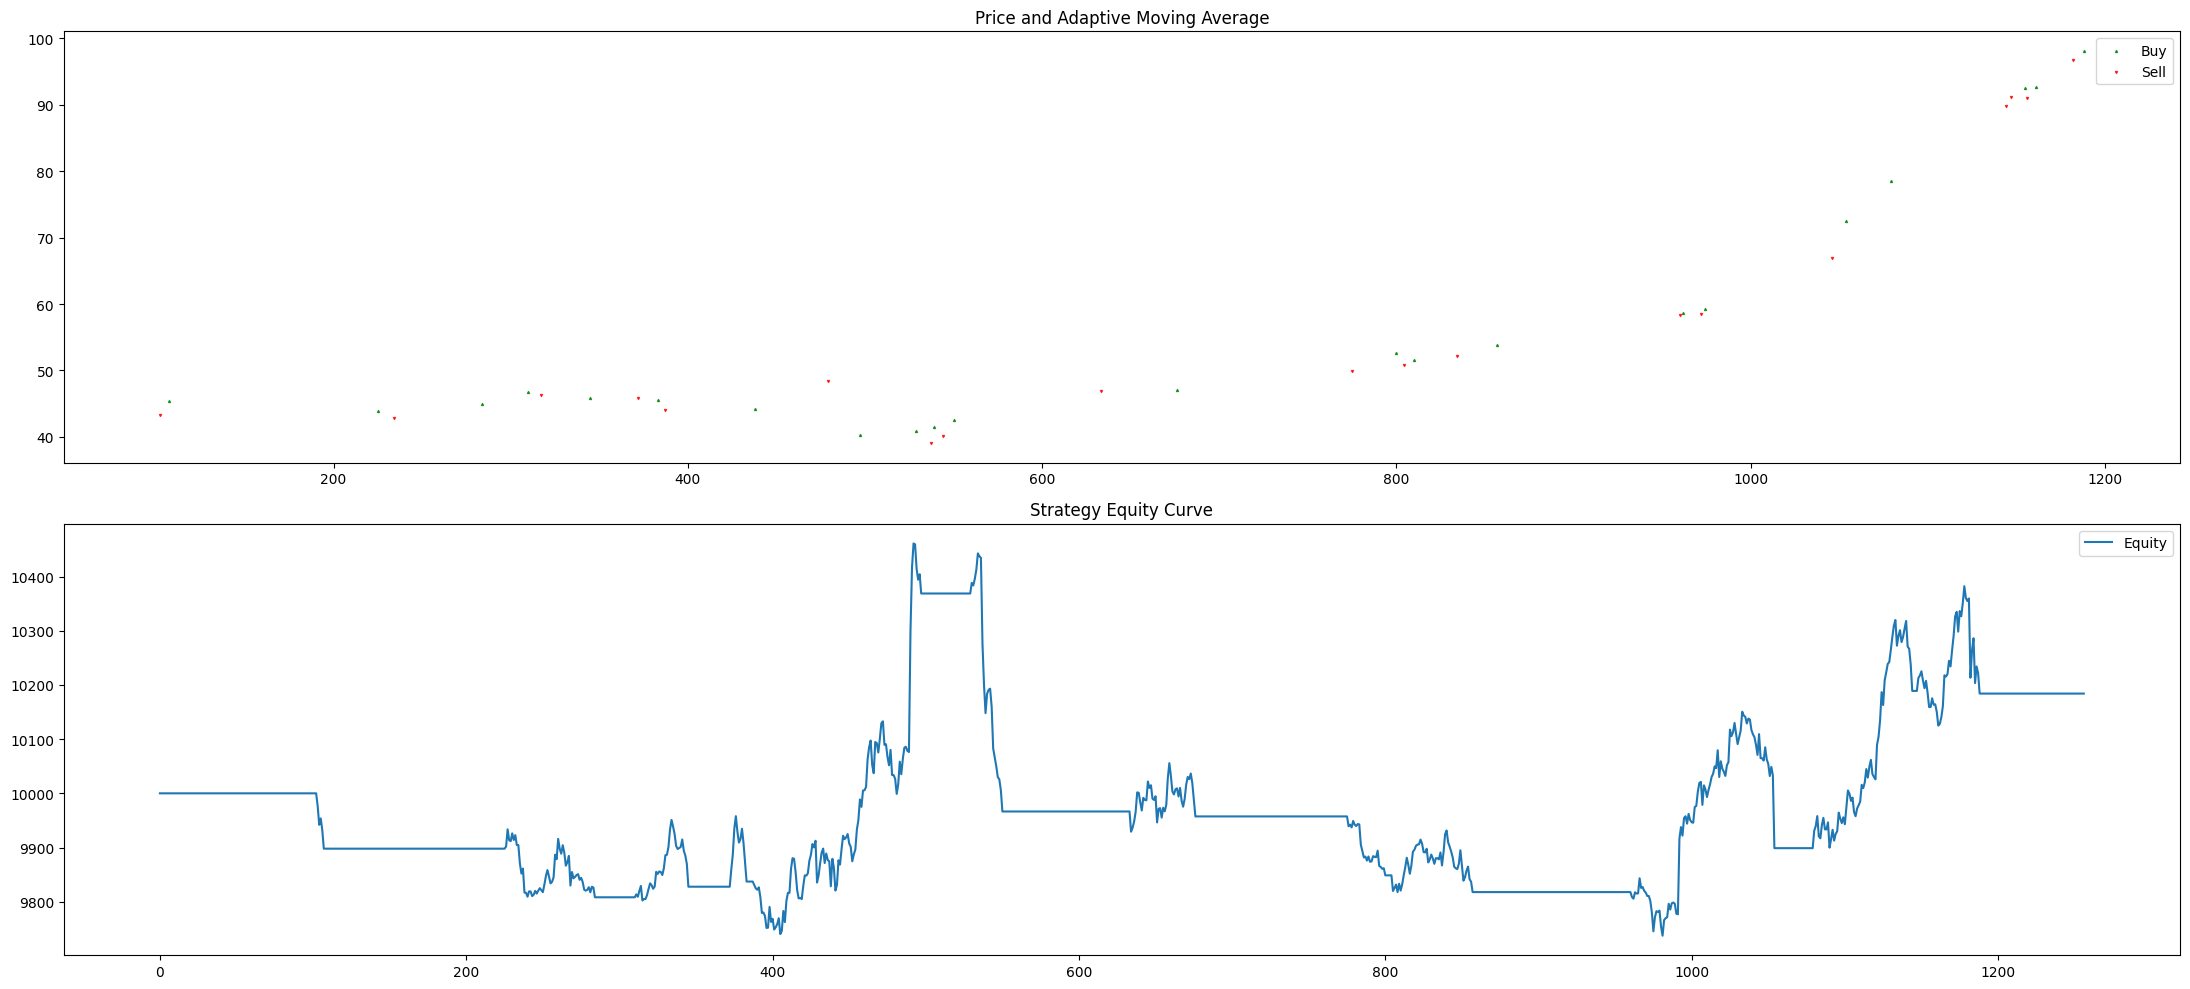

In [127]:
def benchrun(fast_length, slow_length, window, stop_loss):
    # 创建策略实例 
    strategy = AMAStrategy(fast_length, slow_length, window, stop_loss)
    # 回测策略
    returns, equity, trades = strategy.backtest(df)
    # 计算性能指标
    total_return = equity[-1] / equity[0] - 1 
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
    max_drawdown = (np.maximum.accumulate(equity) - equity).max() / np.maximum.accumulate(equity).max()
          
    print("\nUSD/JPY Strategy Performance:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")    
    # 绘制结果
    strategy.plot_results(df['Close'].values, equity, trades)
    return total_return,sharpe_ratio, max_drawdown, trades 
 
fast = 3
slow = 25
window = 16
stop_loss = 0.05
rr, sharpie, maxdd, trades = benchrun(fast, slow, window, stop_loss)  
